<a href="https://colab.research.google.com/github/Raj0978/Parcil_Safety/blob/Product-%26-Customer/ST100_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division


In [ ]:
shopify=pd.read_excel('Shopify_CustomerSales.xlsx')

In [ ]:
shopify.columns

Index(['Date', 'product_title', 'variant_title', 'variant_sku', 'order_id',
       'customer_id', 'customer_name', 'customer_type', 'customer_email',
       'sale_kind', 'shipping_city', 'shipping_region', 'shipping_country',
       'net_quantity', 'gross_sales', 'discounts', 'returns', 'net_sales',
       'taxes', 'total_sales', 'customers'],
      dtype='object')

In [ ]:
cx=shopify[shopify['variant_sku'].str.contains('ST-100X',case=False)|shopify['variant_sku'].str.contains('P-D-1|N-B-0|N-B-1|N-B-1-A',case=False)]

In [ ]:
cx.shape

(8769, 21)

In [ ]:
# Filter customers who bought products containing "ST-100"
customers_with_ST_100 = cx[cx['variant_sku'].str.contains('ST-100', case=False)]

# Filter customers who bought products containing filters
customers_with_filters = cx[cx['variant_sku'].str.contains('P-D-1|N-B-0|N-B-1|N-B-1-A', case=False)]

# Find customers who bought both products (Mask and Filter)
customers_bought_both = customers_with_ST_100[
    customers_with_ST_100['customer_id'].isin(customers_with_filters['customer_id'])
]

# Find customers who bought PD-100 but not P-A-1
st100 = customers_with_ST_100[
    ~customers_with_ST_100['customer_id'].isin(customers_with_filters['customer_id'])
]

In [ ]:
st100.shape

(3530, 21)

In [ ]:
st100['customer_id'].nunique()

2816

In [ ]:
st100['Date']=pd.to_datetime(st100['Date'])

In [ ]:
recency=pd.DataFrame(st100['customer_id'].unique())
recency.columns=['customer_id']

In [ ]:
max_purchase=st100.groupby('customer_id').Date.max().reset_index()
max_purchase.columns=['customer_id','MaxPurchaseDate']

In [ ]:
max_purchase['recency']=(max_purchase['MaxPurchaseDate'].max()-max_purchase['MaxPurchaseDate']).dt.days

In [ ]:
customers=pd.merge(recency,max_purchase[['customer_id','recency']],on='customer_id')
# customers['recency'] = customers['recency_x']
# customers.drop(['recency_x', 'recency_y'], axis=1, inplace=True)

In [ ]:
customers.head()

,customer_id,recency
0,6657521123584,86
1,6657867710720,86
2,6056785510656,379
3,6235450736896,379
4,6236047540480,379


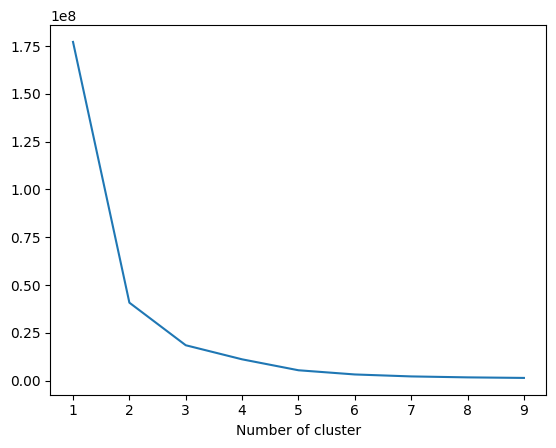

In [ ]:
from sklearn.cluster import KMeans

sse={}
tx_recency = customers[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customers[['recency']])
customers['recencyCluster'] = kmeans.predict(customers[['recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customers = order_cluster('recencyCluster', 'recency',customers,False)

In [ ]:
customers.groupby('recencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recencyCluster,,,,,,,,
0,533.0,727.711069,111.263282,574.0,636.0,686.0,833.00,925.0
1,610.0,414.162295,74.853342,268.0,371.0,416.0,479.75,568.0
2,1673.0,121.829647,71.611569,0.0,52.0,139.0,171.00,267.0


In [ ]:
freq=st100.groupby('customer_id').Date.count().reset_index()
freq.columns=['customer_id','frequency']

In [ ]:
freq[freq['frequency']==1].shape

(2324, 2)

In [ ]:
customers=pd.merge(customers,freq,on='customer_id')


In [ ]:
customers.head()

,customer_id,recency,recencyCluster,frequency
0,6657521123584,86,2,1
1,6657867710720,86,2,1
2,6437280481536,247,2,1
3,6641989878016,53,2,2
4,6637727973632,102,2,1


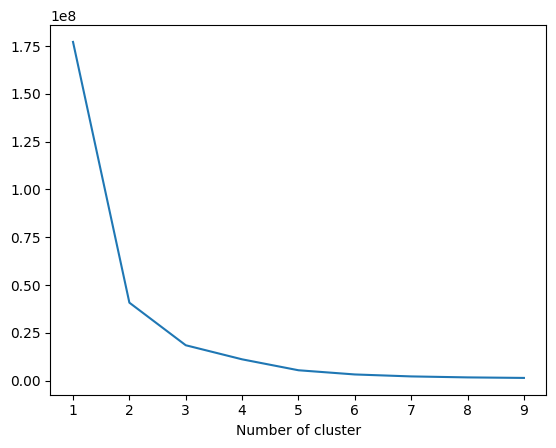

In [ ]:
from sklearn.cluster import KMeans

sse={}
tx_frequency = customers[['frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customers[['frequency']])
customers['frequencyCluster'] = kmeans.predict(customers[['frequency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customers = order_cluster('frequencyCluster', 'frequency',customers,True)

In [ ]:
customers.groupby('frequencyCluster')['frequency'].describe()


,count,mean,std,min,25%,50%,75%,max
frequencyCluster,,,,,,,,
0,2324.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,436.0,2.112385,0.316203,2.0,2.0,2.0,2.0,3.0
2,56.0,5.089286,2.020592,4.0,4.0,4.0,6.0,16.0


In [ ]:
customers[customers['frequency']==16]

,customer_id,recency,recencyCluster,frequency,frequencyCluster
2780,5083529248928,253,2,16,2


In [ ]:
rev=st100.groupby('customer_id').total_sales.sum().reset_index()

In [ ]:
customers=pd.merge(customers,rev,on='customer_id')

In [ ]:
customers['revenue']=customers['total_sales']
customers.drop(['total_sales'],axis=1,inplace=True)
customers.head()

,customer_id,recency,recencyCluster,frequency,frequencyCluster,revenue
0,6657521123584,86,2,1,0,150.12
1,6657867710720,86,2,1,0,114.68
2,6437280481536,247,2,1,0,149.97
3,6637727973632,102,2,1,0,150.12
4,6641567826176,102,2,1,0,195.95


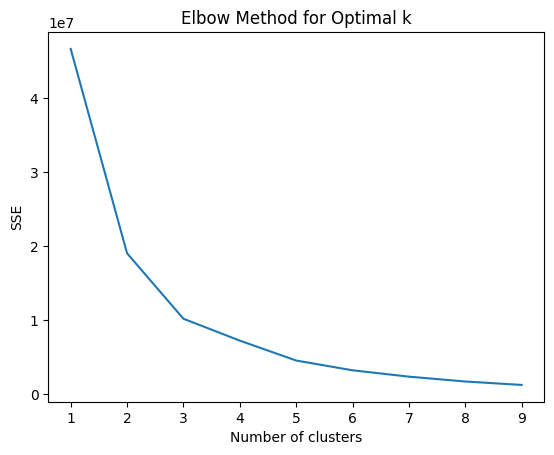

In [ ]:
sse = {}
# Assuming 'recency' and 'revenue' are columns in the 'customers' DataFrame
tx_revenue = customers[['customer_id', 'revenue']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue[['revenue']])
    tx_revenue["clusters"] = kmeans.labels_

    # Merge the clustered 'tx_revenue' DataFrame back to the 'customers' DataFrame
    customers = pd.merge(customers, tx_revenue[['customer_id', 'clusters']], on='customer_id')

    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customers[['revenue']])
customers['revenueCluster'] = kmeans.predict(customers[['revenue']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customers = order_cluster('revenueCluster','revenue',customers,True)

In [ ]:
customers.groupby('revenueCluster')['revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
revenueCluster,,,,,,,,
0,2004.0,119.520135,43.836368,0.00,103.9700,139.97,149.770,200.04
1,674.0,280.567685,54.505290,200.26,234.2125,279.94,305.905,427.87
2,138.0,581.951304,177.900276,432.09,468.8750,524.54,600.470,1668.61


In [ ]:
customers['OverallScore'] = customers['recencyCluster'] + customers['frequencyCluster'] + customers['revenueCluster']
customers.groupby('OverallScore')['recency','frequency','revenue'].mean()

,recency,frequency,revenue
OverallScore,,,
0,731.428218,1.000000,111.297896
1,481.564334,1.047404,147.801625
2,174.534014,1.062925,142.659949
3,162.687279,1.484099,245.639982
4,163.762431,2.176796,370.198950
5,195.410256,3.743590,512.165641
6,129.285714,4.571429,672.711429


In [ ]:
customers.groupby('OverallScore')['recency','frequency','revenue'].describe()

recency                                                        \
               count        mean         std    min     25%    50%     75%   
OverallScore                                                                 
0              404.0  731.428218  109.598760  574.0  640.75  701.5  835.25   
1              443.0  481.564334  147.871680  268.0  387.00  430.0  529.00   
2             1176.0  174.534014  152.945989    0.0   53.00  149.0  232.00   
3              566.0  162.687279  127.965189    0.0   53.00  148.0  227.25   
4              181.0  163.762431  108.279494    6.0   99.00  151.0  222.00   
5               39.0  195.410256  141.802442    7.0   53.00  153.0  241.50   
6                7.0  129.285714   85.694641   50.0   53.00   95.0  210.50   

                    frequency            ...            revenue              \
                max     count      mean  ...  75%   max   count        mean   
OverallScore                             ...                                  
0             922.0     404.0  1.000000  ...  1.0   1.0   404.0  111.297896   
1             925.0     443.0  1.047404  ...  1.0   3.0   443.0  147.801625   
2             900.0    1176.0  1.062925  ...  1.0   3.0  1176.0  142.659949   
3             896.0     566.0  1.484099  ...  2.0   8.0   566.0  245.639982   
4             586.0     181.0  2.176796  ...  2.0  16.0   181.0  370.198950   
5             555.0      39.0  3.743590  ...  4.0   9.0    39.0  512.165641   
6             233.0       7.0  4.571429  ...  5.0   6.0     7.0  672.711429   

                                                                    
                     std     min     25%      50%     75%      max  
OverallScore                                                        
0              35.670565    0.00   89.98  119.975  139.94   179.96  
1              70.433043    0.00  112.47  139.970  153.62   419.91  
2              77.544880    0.00  104.98  139.970  152.92   783.90  
3             123.654378    0.00  159.72  225.180  299.94   892.32  
4             197.233668    0.00  251.70  306.620  471.77  1399.70  
5             165.418089  299.92  429.91  471.770  594.88  1079.76  
6             443.559453  456.70  457.78  479.890  594.11  1668.61  

[7 rows x 24 columns]

In [ ]:
## Define the conditions and corresponding segment values
conditions = [
    customers['OverallScore'] > 4,
    customers['OverallScore'] > 2,
]
choices = ['High-Value', 'Mid-Value']

# Use np.select to create a new 'Segment' column based on conditions
customers['Segment'] = np.select(conditions, choices, default='Low Value')

customers=pd.merge(customers,st100[['customer_name','customer_email','customer_id','shipping_region']],on='customer_id')


# Group by 'customer_id' and keep the first row for each customer
customers = customers.groupby('customer_id').first().reset_index()

In [ ]:
# customers=pd.merge(customers,st100[['customer_name','customer_email','customer_id','shipping_region']],on='customer_id')


In [ ]:
customers.columns

Index(['customer_id', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'revenue', 'clusters_x', 'clusters_y', 'clusters_x',
       'clusters_y', 'clusters_x', 'clusters_y', 'clusters_x', 'clusters_y',
       'clusters', 'revenueCluster', 'OverallScore', 'Segment',
       'customer_name', 'customer_email', 'shipping_region'],
      dtype='object')

In [ ]:
customers.shape

(2816, 21)

In [ ]:
from google.colab import files
# customers.to_excel('customers_st100.xlsx',index=False)
# files.download('customers_st100.xlsx')

In [ ]:
target=customers[(customers['Segment']== 'Low Value')|(customers['Segment']== 'Mid-Value') ]
target.head()

,customer_id,recency,recencyCluster,frequency,frequencyCluster,revenue,clusters_x,clusters_y,clusters_x,clusters_y,...,clusters_y,clusters_x,clusters_y,clusters,revenueCluster,OverallScore,Segment,customer_name,customer_email,shipping_region
0,2449629970491,825,0,1,0,119.97,0,1,0,2,...,0,0,3,6,0,0,Low Value,Kirk Montgomery,kirkm658@gmail.com,California
1,2929914675259,824,0,1,0,119.97,0,1,0,2,...,0,0,3,6,0,0,Low Value,Bruce Gonzalez,nrico20042000@yahoo.com,South Carolina
2,3007358599227,370,1,1,0,143.95,0,1,0,2,...,0,0,3,6,0,1,Low Value,Lee Harrell,leeharrell@gmail.com,Texas
3,3115880611899,51,2,2,1,152.77,0,1,0,2,...,0,0,3,6,0,3,Mid-Value,Jake Golanch,golanch279@hotmail.com,Ontario
4,3172990124091,822,0,1,0,119.97,0,1,0,2,...,0,0,3,6,0,0,Low Value,Deron Kamisato,dkamisat@yahoo.com,Hawaii


In [ ]:
target.drop(['clusters_x','clusters_y','clusters'],axis=1,inplace=True)

In [ ]:
target.head()

,customer_id,recency,recencyCluster,frequency,frequencyCluster,revenue,revenueCluster,OverallScore,Segment,customer_name,customer_email,shipping_region
0,2449629970491,825,0,1,0,119.97,0,0,Low Value,Kirk Montgomery,kirkm658@gmail.com,California
1,2929914675259,824,0,1,0,119.97,0,0,Low Value,Bruce Gonzalez,nrico20042000@yahoo.com,South Carolina
2,3007358599227,370,1,1,0,143.95,0,1,Low Value,Lee Harrell,leeharrell@gmail.com,Texas
3,3115880611899,51,2,2,1,152.77,0,3,Mid-Value,Jake Golanch,golanch279@hotmail.com,Ontario
4,3172990124091,822,0,1,0,119.97,0,0,Low Value,Deron Kamisato,dkamisat@yahoo.com,Hawaii


In [ ]:
import pandas as pd
from scipy import stats
import numpy as np

# Assuming you have a DataFrame named 'target' with 'customer_id', 'recency', 'frequency', and 'revenue' columns

# Calculate the number of customers in each group
group_size = len(target) // 3

# Get the customer IDs from the 'target' DataFrame
customer_ids = target['customer_id'].tolist()

# Shuffle the customer IDs
shuffled_ids = np.random.permutation(customer_ids)

group1 = shuffled_ids[:group_size]
group2 = shuffled_ids[group_size:2 * group_size]
group3 = shuffled_ids[2 * group_size:]

# Split the target DataFrame into groups
group1 = target[target['customer_id'].isin(group1)]
group2 = target[target['customer_id'].isin(group2)]
group3 = target[target['customer_id'].isin(group3)]

# Perform t-tests for recency, frequency, and revenue between groups
recency_p_value_12 = stats.ttest_ind(group1['recency'], group2['recency']).pvalue
recency_p_value_13 = stats.ttest_ind(group1['recency'], group3['recency']).pvalue
recency_p_value_23 = stats.ttest_ind(group2['recency'], group3['recency']).pvalue

frequency_p_value_12 = stats.ttest_ind(group1['frequency'], group2['frequency']).pvalue
frequency_p_value_13 = stats.ttest_ind(group1['frequency'], group3['frequency']).pvalue
frequency_p_value_23 = stats.ttest_ind(group2['frequency'], group3['frequency']).pvalue

revenue_p_value_12 = stats.ttest_ind(group1['revenue'], group2['revenue']).pvalue
revenue_p_value_13 = stats.ttest_ind(group1['revenue'], group3['revenue']).pvalue
revenue_p_value_23 = stats.ttest_ind(group2['revenue'], group3['revenue']).pvalue


In [ ]:
target.head()

,customer_id,recency,recencyCluster,frequency,frequencyCluster,revenue,revenueCluster,OverallScore,Segment,customer_name,customer_email,shipping_region
0,2449629970491,825,0,1,0,119.97,0,0,Low Value,Kirk Montgomery,kirkm658@gmail.com,California
1,2929914675259,824,0,1,0,119.97,0,0,Low Value,Bruce Gonzalez,nrico20042000@yahoo.com,South Carolina
2,3007358599227,370,1,1,0,143.95,0,1,Low Value,Lee Harrell,leeharrell@gmail.com,Texas
3,3115880611899,51,2,2,1,152.77,0,3,Mid-Value,Jake Golanch,golanch279@hotmail.com,Ontario
4,3172990124091,822,0,1,0,119.97,0,0,Low Value,Deron Kamisato,dkamisat@yahoo.com,Hawaii


In [ ]:
group1=pd.merge(group1,target[['customer_id','customer_name','customer_email','shipping_region','OverallScore']],
                on='customer_id',how='left')

In [ ]:
group2=pd.merge(group2,target[['customer_id','customer_name','customer_email','shipping_region','OverallScore']],
                on='customer_id',how='left')

In [ ]:
group3=pd.merge(group3,target[['customer_id','customer_name','customer_email','shipping_region','OverallScore']],
                on='customer_id',how='left')

In [ ]:
group1.to_excel('st100_NoDiscount.xlsx',index=False)
group2.to_excel('st100_SmallDiscount.xlsx',index=False)
group3.to_excel('st100_LargeDiscount.xlsx',index=False)

In [ ]:
files.download('st100_NoDiscount.xlsx')
files.download('st100_SmallDiscount.xlsx')
files.download('st100_LargeDiscount.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reset index and set 'Date' as the new index
st100 = st100.reset_index().set_index('Date')

# Resample by month ('MS') and sum the 'total_cost' column
resampled_data = st100['total_sales'].resample(rule="MS").sum()

# Plot the data
resampled_data.plot()

In [ ]:
import joblib
import plotnine as pn

In [ ]:
HV=customers[customers['Segment']=='High-Value']

In [ ]:
HV.shape

In [ ]:
ids_selected=HV['customer_id']
ids_selected.count()

In [ ]:
subset_st100=st100[st100['customer_id'].isin(ids_selected)].groupby(['customer_id','Date']).sum().reset_index()

In [ ]:
subset_st100 = subset_st100[['Date','customer_id','net_quantity','total_sales']]
subset_st100

In [ ]:
# Convert 'Date' to a DateTimeIndex
subset_st100['Date'] = pd.to_datetime(subset_st100['Date'])

# Plot using plotnine
plot = pn.ggplot(
    data=subset_st100,
    mapping=pn.aes(x='Date', y='total_sales', group='customer_id')
) + pn.geom_line() + pn.geom_point() + pn.facet_wrap('customer_id') + pn.scale_x_date(date_breaks="1 year", date_labels="%Y")

print(plot)

In [ ]:
# Convert 'Date' to a DateTimeIndex
subset_st100['Date'] = pd.to_datetime(subset_st100['Date'])

# Plot using plotnine with facets in a grid
plot_grid_customers = pn.ggplot(
    data=subset_st100,
    mapping=pn.aes(x='Date', y='total_sales', group='customer_id')
) + pn.geom_line() + pn.geom_point() + pn.facet_wrap('customer_id', scales='free_y', ncol=3) + pn.scale_x_date(date_breaks="1 year", date_labels="%Y")

print(plot_grid_customers)

In [ ]:
# Convert 'Date' to a DateTimeIndex
subset_st100['Date'] = pd.to_datetime(subset_st100['Date'])

# Calculate total cost for each customer
customer_total_cost = subset_st100.groupby('customer_id')['total_sales'].sum().reset_index()

# Select the top N customers (e.g., top 10)
top_n_customers = customer_total_cost.nlargest(10, 'total_sales')['customer_id'].tolist()

# Filter the original data for the top customers
subset_top_customers = subset_st100[subset_st100['customer_id'].isin(top_n_customers)]

# Plot using plotnine with the top customers
plot_top_customers = pn.ggplot(
    data=subset_top_customers,
    mapping=pn.aes(x='Date', y='total_sales', group='customer_id')
) + pn.geom_line() + pn.geom_point() + pn.facet_wrap('customer_id') + pn.scale_x_date(date_breaks="1 year", date_labels="%Y")

print(plot_top_customers)

In [ ]:
subset_st100.columns